# Seventh Classifier

No image data, since the classifiers are prone to latching onto missing image counts. We leave age data, because that's a pretty useful metric according to the research and it fits with the ground truth. (The danger here is that ground truth is probably biased in a nonrepresentative way in favor of age.)

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}
image_cols = {x for x in df.columns if x.find('image') > -1}
age_cols = {x for x in df.columns if x.find('age') > -1} | set(['flag_Juvenile'])
service_cols = {x for x in df.columns if x.find('incall') > -1 or x.find('outcall') > -1}
lattice_cols = flag_cols | ethnicity_cols | service_cols

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - image_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 301)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.8481830065359478


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.600000,0.929825,0.980392,0.500000,0.687908
1,0.307692,0.842105,0.901961,0.333333,0.799020
2,0.250000,0.789474,0.843137,0.333333,0.638889
3,0.240000,0.666667,0.686275,0.500000,0.820261
4,0.300000,0.754386,0.784314,0.500000,0.794118
5,0.600000,0.929825,0.980392,0.500000,0.862745
6,0.727273,0.947368,0.980392,0.666667,0.946078
7,0.600000,0.929825,0.980392,0.500000,0.942810
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.909091,0.981818,0.980000,1.000000,0.990000


                                 feature     score
0                                age:max  0.031929
1                                  n_ads  0.030856
2         distinct_locations:nmlzd_count  0.030271
3                          flag_Juvenile  0.025332
4                   location_tree_length  0.023282
5                                age:min  0.022799
6         incall_and_outcall:nmlzd_count  0.020355
7                               age:mean  0.019606
8                                age:25%  0.017346
9                     incall:nmlzd_count  0.017242
10                               age:75%  0.016462
11                               age:std  0.016381
12                               age:50%  0.016260
13                       missing_age:std  0.015963
14                       ethnicity_Ebony  0.015733
15                      missing_age:mean  0.015601
16                        flag_Traveling  0.014592
17                flag_Foreign Providers  0.014348
18                   outcall:nm

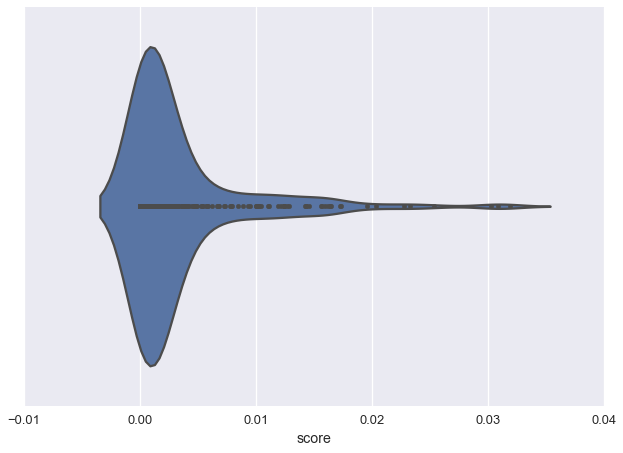

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False).reset_index()
ranked_imptncs.columns = ['feature', 'score']
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs.score, inner='point')

In [9]:
print('Ethnicity: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(ethnicity_cols), :].sum().score))
print('Age: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(age_cols), :].sum().score))
print('Service: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(service_cols), :].sum().score))
print('Lattice: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(lattice_cols), :].sum().score))
print('Price: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(price_cols), :].sum().score))
print('Duration: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(duration_cols), :].sum().score))

Ethnicity: 0.272630000480117
Age: 0.28548650980654716
Service: 0.05193662202876808
Lattice: 0.4533152223088341
Price: 0.1367689534331506
Duration: 0.06671163040831032


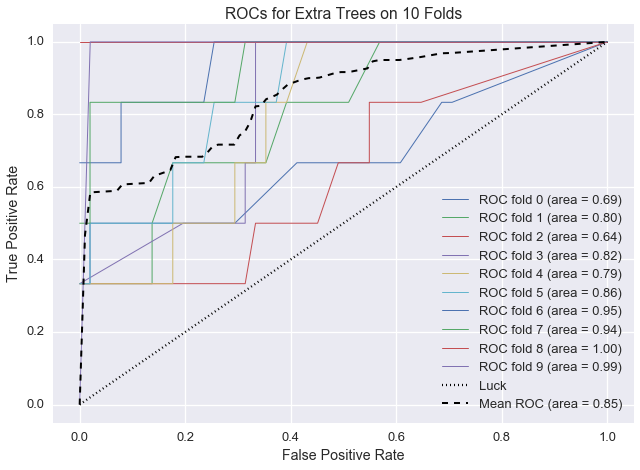

In [10]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [11]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [12]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.8514509803921569


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.444444,0.912281,0.980392,0.333333,0.784314
1,0.307692,0.842105,0.901961,0.333333,0.774510
2,0.250000,0.789474,0.843137,0.333333,0.633987
3,0.240000,0.666667,0.686275,0.500000,0.803922
4,0.210526,0.736842,0.784314,0.333333,0.781046
5,0.444444,0.912281,0.980392,0.333333,0.897059
6,0.727273,0.947368,0.980392,0.666667,0.898693
7,0.600000,0.929825,0.980392,0.500000,0.950980
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.909091,0.981818,0.980000,1.000000,0.990000


                                 feature     score
0         distinct_locations:nmlzd_count  0.041427
1                                  n_ads  0.040593
2                                age:min  0.037235
3                                age:max  0.035171
4                               age:mean  0.026016
5              missing_price:nmlzd_count  0.025588
6                                age:std  0.024999
7                missing_age:nmlzd_count  0.022773
8      missing_price_per_min:nmlzd_count  0.021791
9   missing_duration_in_mins:nmlzd_count  0.021115
10        incall_and_outcall:nmlzd_count  0.021025
11                  location_tree_length  0.020760
12                               age:50%  0.020653
13                               age:25%  0.019694
14                       age:nmlzd_count  0.018495
15                         flag_Juvenile  0.018157
16        cooccurring_phones:nmlzd_count  0.017333
17                               age:75%  0.016604
18                      missing

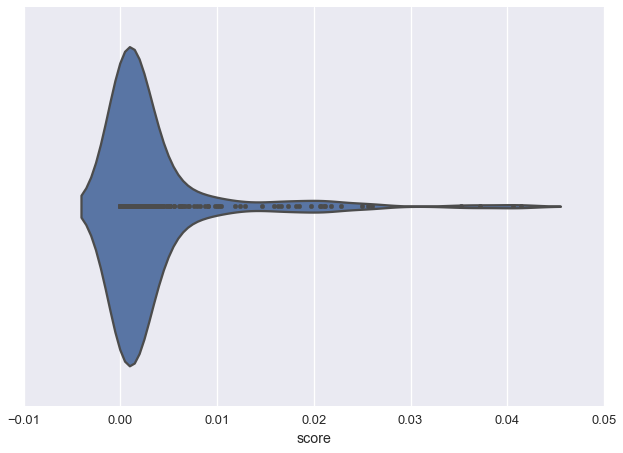

In [13]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False).reset_index()
ranked_imptncs.columns = ['feature', 'score']
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs.score, inner='point')

In [14]:
print('Ethnicity: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(ethnicity_cols), :].sum().score))
print('Age: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(age_cols), :].sum().score))
print('Service: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(service_cols), :].sum().score))

Ethnicity: 0.2518171992344755
Age: 0.310232430678014
Service: 0.04337162017778044


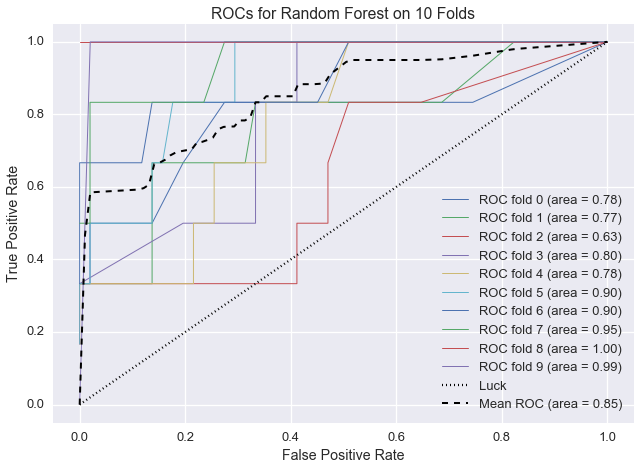

In [15]:
draw_rocs(this_metrics, 'Random Forest')